This work derives from the works of Michael Halls-Moore on [Quantstart](https://www.quantstart.com/) and  [Quantopian Lecture Series](https://www.quantopian.com/lectures/).

# Integration, Cointegration, and Stationarity


In [1]:
import numpy as np
import pandas as pd

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt

## Stationarity/Non-Stationarity

A commonly untested assumption in time series analysis is the stationarity of the data. Data are stationary when the parameters of the data generating process do not change over time. 

*Mean of a time series $x_t$ is $E(x_t)=\mu(t)$*

*Variance of a time series $x_t$ is $\sigma^2(t)=E[(x_t - \mu(t))^2]$*

**A time series is stationary in the mean if $\mu(t)=\mu$, i.e.mean is constant with time**

**A time series is stationary in the variance if $\sigma^2(t)=\sigma^2$, i.e. variance is constant with time**

As an example, let's consider two series, A and B. Series A is generated from a stationary process with fixed parameters, series B is generated with parameters that change over time.

In [2]:
def generate_datapoint(params):
    mu = params[0]
    sigma = params[1]
    return np.random.normal(mu, sigma)

Series A

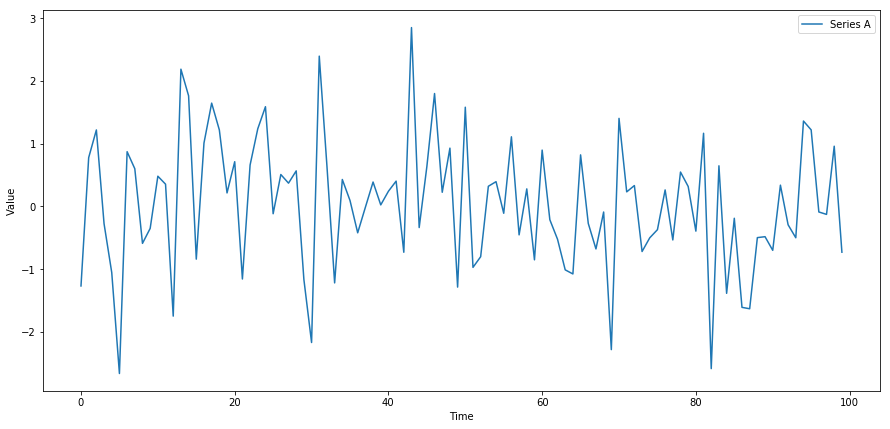

In [52]:
# Set the parameters and the number of datapoints
params = (0, 1)
T = 100

A = pd.Series(index=range(T))
A.name = 'A'

for t in range(T):
    A[t] = generate_datapoint(params)
plt.figure(figsize=(15,7))
plt.plot(A)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A'])
plt.show()

Series B

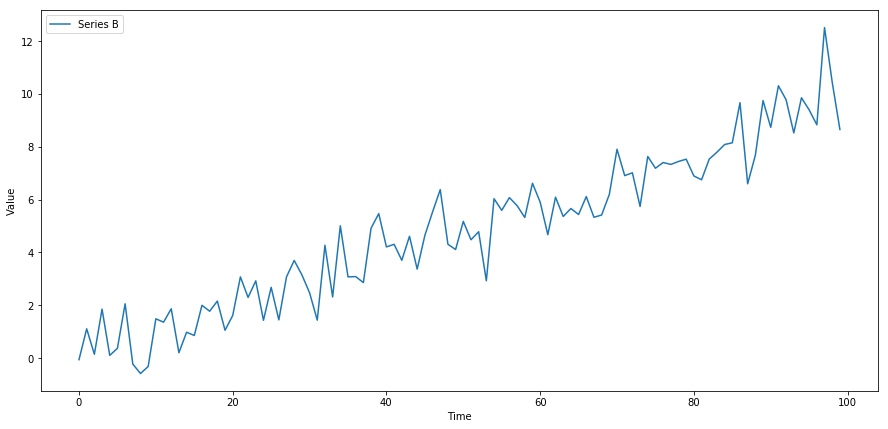

In [53]:
# Set the number of datapoints
T = 100

B = pd.Series(index=range(T))
B.name = 'B'

for t in range(T):
    # Now the parameters are dependent on time
    # Specifically, the mean of the series changes over time
    params = (t * 0.1, 1)
    B[t] = generate_datapoint(params)
plt.figure(figsize=(15,7))
plt.plot(B)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series B'])
plt.show()

This image from SEANABU.COM should help 

![Courtsey: SEANABU.COM ](download.png)

### Why Non-Stationarity is Dangerous

Many statistical tests, deep down in the fine print of their assumptions, require that the data being tested are stationary. A stationary time series (TS) is simple to predict as we can assume that future statistical properties are the same or proportional to current statistical properties.If you naively use certain statistics on a non-stationary data set, you will get garbage results. As an example, let's take an average through our non-stationary $B$.

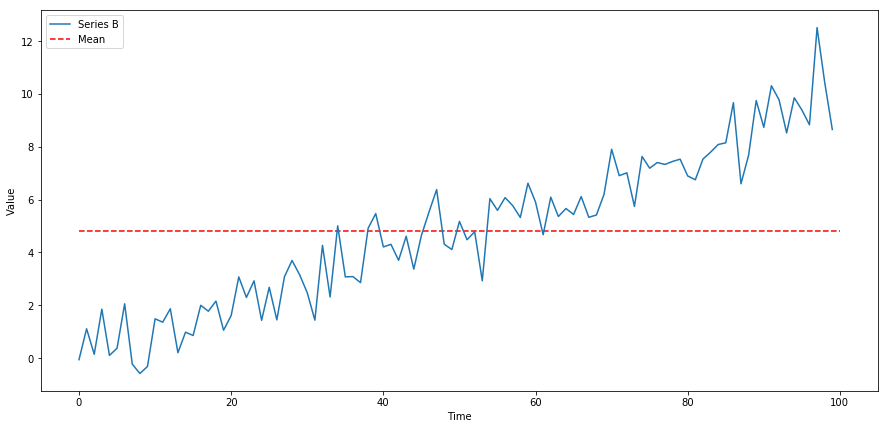

In [54]:
m = np.mean(B)
plt.figure(figsize=(15,7))
plt.plot(B)
plt.hlines(m, 0, len(B), linestyles='dashed', colors='r')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series B', 'Mean'])
plt.show()

The computed mean will show the mean of all data points till date, but won't be useful for any forecasting of future state. It's meaningless when compared with any specfic time, as it's a collection of different states at different times mashed together. This is just a simple and clear example of why non-stationarity can screw with analysis, much more subtle problems can arise in practice.

### Testing for Stationarity

Now we want to check for stationarity using a statistical test. We performthe standard [Augmented Dickey Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test)

In [58]:
def check_for_stationarity(X, cutoff=0.01):
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
        return True
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')
        return False

In [59]:
check_for_stationarity(A);
check_for_stationarity(B);

p-value = 7.34551801775e-20 The series A is likely stationary.
p-value = 0.982699395891 The series B is likely non-stationary.


Sure enough, the changing mean of the series makes it non-stationary. Let's try an example that might be a little more subtle.

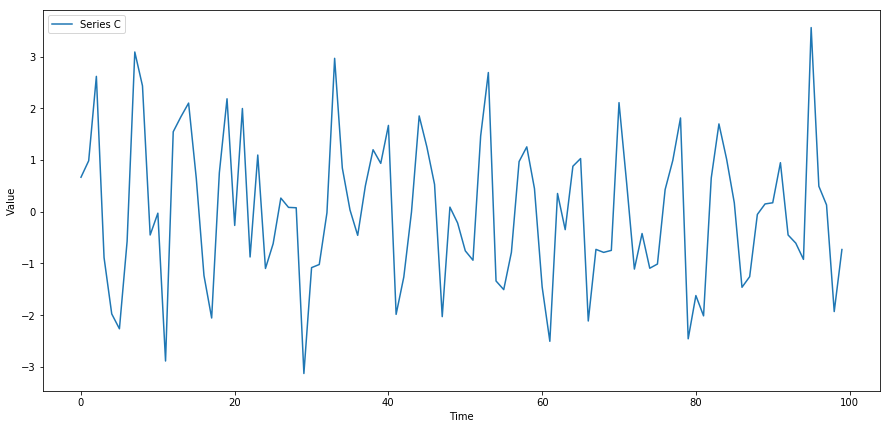

In [60]:
# Set the number of datapoints
T = 100

C = pd.Series(index=range(T))
C.name = 'C'

for t in range(T):
    # Now the parameters are dependent on time
    # Specifically, the mean of the series changes over time
    params = (np.sin(t), 1)
    C[t] = generate_datapoint(params)
plt.figure(figsize=(15,7))
plt.plot(C)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series C'])
plt.show()

A cyclic movement of the mean will be very difficult to tell apart from random noise. In practice on noisy data and limited sample size it can be hard to determine if a series is stationary and whether any drift is random noise or part of a trend. In each individual case the test may or may not pick up subtle effects like this.

In [61]:
check_for_stationarity(C);

p-value = 9.96108840867e-15 The series C is likely stationary.


Let's try this out on some real pricing data.

In [70]:
import auquanToolbox.dataloader as dl

end = '2015-01-01'
start = '2007-01-01'
symbols = ['SPX','AAPL']
data = dl.load_data_nologs('nasdaq', symbols , start, end)['ADJ CLOSE']

X = data['AAPL']

Reading SPX
Reading AAPL


In [71]:
check_for_stationarity(X);

p-value = 0.989212880403 The series AAPL is likely non-stationary.


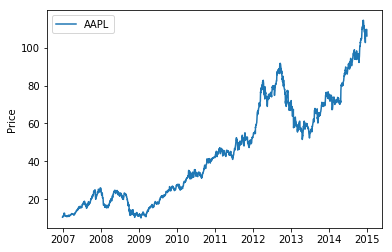

In [72]:
plt.plot(X.index, X.values)
plt.ylabel('Price')
plt.legend([X.name])
plt.show()

Now let's take the delta of the series, giving us the additive returns. We'll check if this is stationary.

p-value = 4.49727767774e-27 The series AAPL Additive Returns is likely stationary.


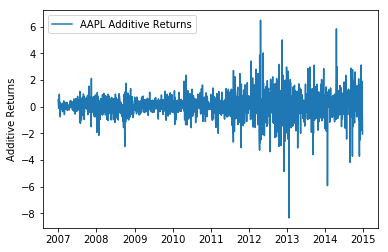

In [73]:
X1 = X.diff()[1:]
X1.name = X.name + ' Additive Returns'
check_for_stationarity(X1)
plt.plot(X1.index, X1.values)
plt.ylabel('Additive Returns')
plt.legend([X1.name])
plt.show()

Seems like the additive returns are stationary. That means we will probably be able to model the returns much better than the price. It also means that the price was $I(1)$.

Let's also check the multiplicative returns.

p-value = 0.0 The series AAPL Multiplicative Returns is likely stationary.


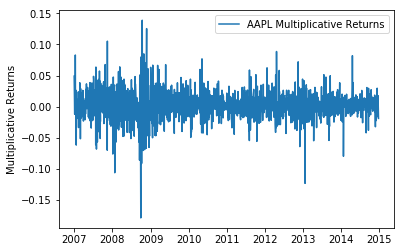

In [74]:
X1 = X.pct_change()[1:]
X1.name = X.name + ' Multiplicative Returns'
check_for_stationarity(X1)
plt.plot(X1.index, X1.values)
plt.ylabel('Multiplicative Returns')
plt.legend([X1.name])
plt.show()

Seems like the multiplicative returns are also stationary. Both the multiplicative and additive deltas on a series get at similar pieces of information, so it's not surprising both are stationary. In practice this might not always be the case.

### IMPORTANT NOTE

As always, you should not naively assume that because a time series is stationary in the past it will continue to be stationary in the future. Tests for consistency of stationarity such as cross validation and out of sample testing are necessary. This is true of any statistical property, we just reiterate it here. Returns may also go in and out of stationarity, and may be stationary or non-stationary depending on the timeframe and sampling frequency.



### Note: Returns Analysis

The reason returns are usually used for modeling in quantitive finance is that they are far more stationary than prices. This makes them easier to model and returns forecasting more feasible. Forecasting prices is more difficult, as there are many trends induced by their $I(1)$ integration. Even using a returns forecasting model to forecast price can be tricky, as any error in the returns forecast will be magnified over time.

## Order of Integration

### Moving Average Representation

An important concept in time series analysis is moving average representation. We will discuss this briefly here, but a more complete explanation is available in the [AR, MA](https://github.com/Auquan/Tutorials/blob/master/Time%20Series%20Analysis%20-%202.ipynb) and [ARMA Models](https://github.com/Auquan/Tutorials/blob/master/Time%20Series%20Analysis%20-%203.ipynb) sheets. Also check Wikipedia as listed below.

This representation expresses any time series $Y_t$ as 

$$Y_t = \sum_{j=0}^\infty b_j \epsilon_{t-j} + \eta_t$$

* $\epsilon$ is the residuals or errors - a stochastic white noise process
* $b_j$ are the moving average weights of residuals
* $\eta$ is a deterministic series

$\eta$ is deterministic (such as a sine wave),something we could perfectly model it. The difference between predictions from this model ($\eta$) and actual observations leads to residuals($\epsilon$). The residuals are stochastic and there to simulate new information occuring over time. 

Specifically, $\epsilon_t = \hat Y_t - Y_t$ where $\hat Y_t$ is the in the optimal forecast of $Y_t$(actual observed value) using only information from time before $t$. In other words, the best prediction you can make at time $t-1$ cannot account for the randomness in $\epsilon$.

Each $b_j$ just says how much previous values of $\epsilon$ influence $Y_t$.


### Back to Order of Integration

We will note integration order-i as $I(i)$.

A time series is said to be $I(0)$ if the following condition holds in a moving average representation. In simpler terms, the autocorrelation of the series decays to 0 sufficiently quickly.

$$\sum_{k=0}^\infty |b_k|^2 < \infty$$

This property turns out to be true of all stationary series since autocorrelation is 0, but by itself is not enough for stationarity to hold. This means that stationarity implies $I(0)$, but $I(0)$ does not imply stationarity. For more on orders of integration, please see the following links.

https://en.wikipedia.org/wiki/Order_of_integration

https://en.wikipedia.org/wiki/Wold%27s_theorem

### Testing for $I(0)$

In practice testing whether the sum of the autocorrelations is finite may not be possible. It is possible in a mathematical derivation, but when we have a finite set of data and a finite number of estimated autocorrelations, the sum will always be finite. Given this difficulty, tests for $I(0)$ rely on stationarity implying the property. If we find that a series is stationary, then it must also be $I(0)$.

Let's take our original stationary series A. Because A is stationary, we know it's also $I(0)$.

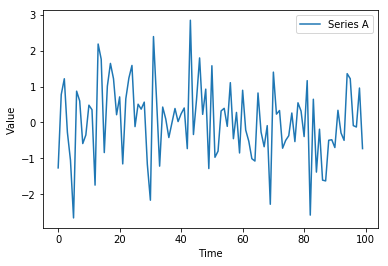

In [68]:
plt.plot(A)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A'])
plt.show()

### Building Up Orders of Integration

If one takes an $I(0)$ series and cumulatively sums it (discrete integration), the new series will be $I(1)$. Notice how this is related to the calculus concept of integration. The same relation applies in general, to get $I(n)$ take an $I(0)$ series and iteratively take the cumulative sum $n$ times.

Now let's make an $I(1)$ series by taking the cumulative sum of A.

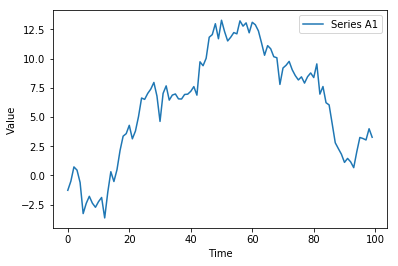

In [69]:
A1 = np.cumsum(A)

plt.plot(A1)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A1'])
plt.show()

**Once all the math has settled, remember that any stationary series is $I(0)$**

### Cointegration

Finally, now that we've discussed stationarity and order of integration, we can discuss cointegration.

A linear combination of the time series ($X_1$, $X_2$, $\dots$, $X_k$) is a new time series $Y$ constructed as follows for any set of real numbers $b_1 \dots b_k$

$$Y = b_1X_1 + b_2X_2 + \dots + b_kX_k$$

For some set of time series ($X_1$, $X_2$, $\dots$, $X_k$), if all series are $I(1)$, and some linear combination of them is $I(0)$, we say the set of time series is cointegrated.

For example, $X_1$, $X_2$, and $X_3$ are all $I(1)$, and $2X_1 + X_2 + 0X_3 = 2X_1 + X_2$ is $I(0)$. In this case the time series are cointegrated.

#### Intuition

The intuition here is that for some linear combination of the series, the result lacks much auto-covariance and is mostly noise. This is useful for cases such as pairs trading, in which we find two assets whose prices are cointegrated. Since the linear combination of their prices $b_1A_1 + b_2A_2$ is noise, we can bet on the relationship $b_1A_1 + b_2A_2$ mean reverting and place trades accordingly. See the Pairs Trading notebook for more information.

Let's make some data to demonstrate this.

In [43]:
# Length of series
N = 100

# Generate a stationary random X1
X1 = np.random.normal(0, 1, N)
# Integrate it to make it I(1)
X1 = np.cumsum(X1)
X1 = pd.Series(X1)
X1.name = 'X1'

# Make an X2 that is X1 plus some noise
X2 = X1 + np.random.normal(0, 1, N)
X2.name = 'X2'

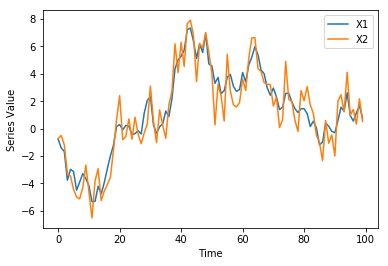

In [44]:
plt.plot(X1)
plt.plot(X2)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend([X1.name, X2.name])
plt.show()

Because $X_2$ is just an $I(1)$ series plus some stationary noise, it should still be $I(1)$. Let's check this.

In [15]:
Z = X2.diff()[1:]
Z.name = 'Z'

check_for_stationarity(Z);

p-value = 1.03652371022e-20 The series Z is likely stationary.


Looks good. Now to show cointegration we'll need to find some linear combination of $X_1$ and $X_2$ that is stationary. We can take $X_2-X_1$. All that's left over should be stationary noise by design. Let's check this.

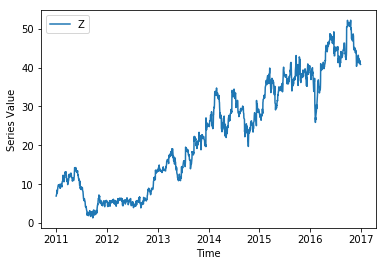

p-value = 0.771138236834 The series Z is likely non-stationary.


In [41]:
Z = X2 - X1
Z.name = 'Z'

plt.plot(Z)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend(['Z'])
plt.show()

check_for_stationarity(Z);

### Testing for Cointegration

There are a bunch of ways to test for cointegration. This [wikipedia article](https://en.wikipedia.org/wiki/Cointegration) describes some. In general we're just trying to solve for the coefficients $b_1, \dots b_k$ that will produce an $I(0)$ linear combination. If our best guess for these coefficients does not pass a stationarity check, then we reject the hypothesis that the set is cointegrated. This will lead to risk of Type II errors (false negatives), as we will not exhaustively test for stationarity on all coefficent combinations. However Type II errors are generally okay here, as they are safe and do not lead to us making any wrong forecasts.

In practice a common way to do this for pairs of time series is to use linear regression to estimate $\beta$ in the following model.

$$X_2 = \alpha + \beta X_1 + \epsilon$$

The idea is that if the two are cointegrated we can remove $X_2$'s depedency on $X_1$, leaving behind stationary noise. The combination $X_2 - \beta X_1 = \alpha + \epsilon$ should be stationary.

Let's try on some real data. We'll get prices and plot them first.

In [30]:
end = '2017-01-01'
start = '2011-01-01'
symbols = ['MSFT','ADBE']
data = dl.load_data_nologs('nasdaq', symbols , start, end)['ADJ CLOSE']

Reading MSFT
Reading ADBE


In [31]:
X1 = data['MSFT']
X2 = data['ADBE']

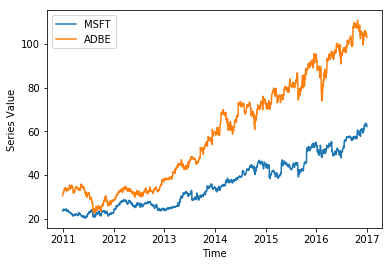

In [35]:
plt.plot(X1)
plt.plot(X2)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend([X1.name, X2.name])
plt.show()

Now use linear regression to compute $\beta$.

In [36]:
X1 = sm.add_constant(X1)
results = sm.OLS(X2, X1).fit()

# Get rid of the constant column
X1 = X1['MSFT']

results.params

const   -17.414721
MSFT      2.114956
dtype: float64

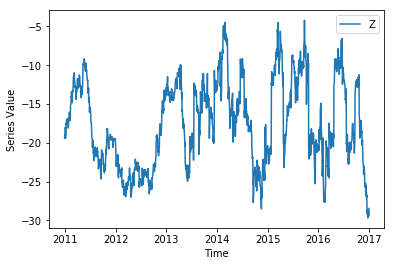

p-value = 0.00484736194367 The series Z is likely stationary.


In [40]:
b = results.params['MSFT']
Z = X2 - b * X1
Z.name = 'Z'

plt.plot(Z.index, Z.values)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend([Z.name])
plt.show()

check_for_stationarity(Z);

We can see here that the resulting $Z$ was likely stationary over the time frame we looked at. This causes us to accept the hypothesis that our two assets were cointegrated over the same timeframe.

**This is only a forecast!**

Remember as with anything else, you should not assume that because some set of assets have passed a cointegration test historically, they will continue to remain cointegrated. You need to verify that consistent behavior occurs, and use various model validation techniques as you would with any model.

One of the most important things done in finance is to make many independent bets. Here a quant would find many pairs of assets they hypothesize are cointegrated, and evenly distribute their dollars between them in bets. This only requires more than half of the asset pairs to remain cointegrated for the strategy to work. 

Luckily there are some pre-built tests for cointegration. Here's one. Read up on the [documentation](http://statsmodels.sourceforge.net/devel/_modules/statsmodels/tsa/stattools.html) on your own time.

In [38]:
from statsmodels.tsa.stattools import coint

coint(X1, X2)

(-3.7855667724973134,
 0.014168263039705158,
 array([-3.9037028 , -3.34017673, -3.04725807]))